# Rossmann Stores Sales Prediction

We're provided with historic data of sales, given this will the future sales of the stores can be predicted.
Predicting a number based on other feature (i.e) Regression Problem.

In [213]:
# import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

TEST_SIZE = 0.2
SEED = 42

## 1. Get the data and getting one with it

In [10]:
!ls data/rossmann-store-sales/

sample_submission.csv test.csv
store.csv             train.csv


In [48]:
train_df = pd.read_csv("data/rossmann-store-sales/train.csv", parse_dates=['Date'])
train_df.set_index(["Date"], inplace=True)
store_df = pd.read_csv("data/rossmann-store-sales/store.csv")

/Users/jayaprakashsivagami/Documents/Tech/ML/Projects/env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [49]:
train_df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1017209 entries, 2015-07-31 to 2013-01-01
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Sales          1017209 non-null  int64 
 3   Customers      1017209 non-null  int64 
 4   Open           1017209 non-null  int64 
 5   Promo          1017209 non-null  int64 
 6   StateHoliday   1017209 non-null  object
 7   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 69.8+ MB


In [25]:
train_df.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


In [50]:
for feature in train_df.columns:
    print(f"""
Value counts for feature {feature}:
{train_df[feature].value_counts()}
    """)


Value counts for feature Store:
1      942
726    942
708    942
709    942
713    942
      ... 
159    758
637    758
636    758
633    758
155    758
Name: Store, Length: 1115, dtype: int64
    

Value counts for feature DayOfWeek:
5    145845
4    145845
3    145665
2    145664
1    144730
7    144730
6    144730
Name: DayOfWeek, dtype: int64
    

Value counts for feature Sales:
0        172871
5674        215
5558        197
5483        196
6214        195
          ...  
23806         1
24183         1
20651         1
25083         1
23303         1
Name: Sales, Length: 21734, dtype: int64
    

Value counts for feature Customers:
0       172869
560       2414
576       2363
603       2337
571       2330
         ...  
4815         1
3998         1
4210         1
4920         1
4065         1
Name: Customers, Length: 4086, dtype: int64
    

Value counts for feature Open:
1    844392
0    172817
Name: Open, dtype: int64
    

Value counts for feature Promo:
0    629129
1    388

In [51]:
# There's 0 and '0' for StateHoliday, let's convert all of them into a string
train_df.StateHoliday = train_df.StateHoliday.astype('str')

In [52]:
train_df.StateHoliday.value_counts()

0    986159
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64

Now that the datatype mismatch for 0 is fixed in `StateHoliday` feature

### Some description for the features of `train_df`

Let's write a one-liner for each feature for better clarity:

1. `Store` - Unique Id for each store
2. `DayOfWeek` - Day of sale in the week with values form 1 to 7 for each day
3. `Date` - Sale date for the datapoint or instance
4. `Customers` - Number of customers on the day
5. `Open` - Whether the store is open or not 0-closed, 1-open
6. `Promo` Indicates whether a store is running a promo on the day
  * `0` - store is not participating
  * `1` - store is participating
7. `StateHoliday` - Indicate the type of stateholiday, all the stores with few exceptions are always closed on holidays
  * `a` - public holiday
  * `b` - easter holiday
  * `c` - christmas holiday
  * `0` - No holiday
8. `SchoolHoliday` - Indicate whether the school is open or not
  * `0` - Open
  * `1` - Closed
9. `Sales` - Sales for the day, the target feature to be predicted

We have only one feature in train dataset `StateHoliday` in object type and can be concluded as a categorical feature because it has only four values. Let's convert it to categorical feature and replace it with cat codes converting it into a numerical making our life easier for eda.

In [60]:
train_df["StateHoliday"] = train_df.StateHoliday.astype("category").cat.as_ordered()

In [61]:
train_df.StateHoliday.dtype

CategoricalDtype(categories=[0, 1, 2, 3], ordered=True)

In [62]:
train_df.StateHoliday.cat.categories

Int64Index([0, 1, 2, 3], dtype='int64')

In [63]:
train_df.StateHoliday.value_counts()

0    986159
1     20260
2      6690
3      4100
Name: StateHoliday, dtype: int64

In [64]:
train_df.StateHoliday = train_df.StateHoliday.cat.codes

In [65]:
train_df.StateHoliday.value_counts()

0    986159
1     20260
2      6690
3      4100
Name: StateHoliday, dtype: int64

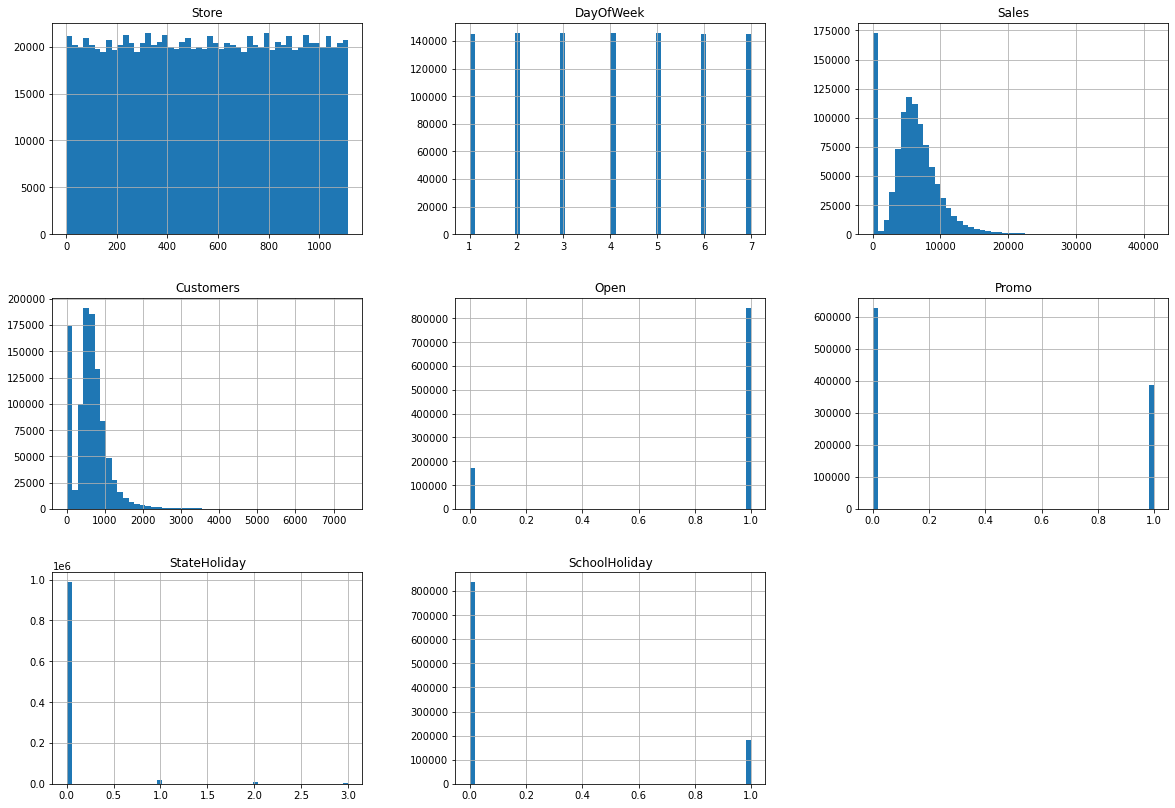

In [68]:
# Let's do a hist for all the features
train_df.hist(figsize=(20, 14), bins=50);

To avoid *Sneak Bias* Let's split the data before going further into EDA of dataset

In [69]:
# Before that let's check for any nan datapoints
train_df.isna().sum()

Store            0
DayOfWeek        0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [72]:
# Splitting features and labels
X, y = train_df.drop("Sales", axis=1), train_df["Sales"]

In [80]:
# Writing a function to see a dataframe's features to get an insight
def dataset_info(df: pd.DataFrame or pd.Series):
    """
    Function accepts a pandas dataframe or series
    and gives information on the dataset
    """
    
    print(f"Shape of dataset is: {df.shape}")
    print(f"Number of dimensions is: {df.ndim}")

In [81]:
dataset_info(X)

Shape of dataset is: (1017209, 7)
Number of dimensions is: 2


In [82]:
dataset_info(y)

Shape of dataset is: (1017209,)
Number of dimensions is: 1


In [87]:
SEED=42
# Splitting the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [88]:
dataset_info(X_train), dataset_info(X_test), dataset_info(y_train), dataset_info(y_test)

Shape of dataset is: (813767, 7)
Number of dimensions is: 2
Shape of dataset is: (203442, 7)
Number of dimensions is: 2
Shape of dataset is: (813767,)
Number of dimensions is: 1
Shape of dataset is: (203442,)
Number of dimensions is: 1


(None, None, None, None)

Let's look if we can get any useful feature from store df to train df before we go any further on train df.

In [17]:
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [19]:
store_df.isna().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [91]:
for feature in store_df.columns:
    print(f"""
Value counts for feature: {feature}
{store_df[feature].value_counts()}
    """)
    print(f"Nan values for {feature} out of total {len(store_df)} is {store_df[feature].isna().sum()}")


Value counts for feature: Store
1       1
742     1
748     1
747     1
746     1
       ..
378     1
379     1
380     1
381     1
1115    1
Name: Store, Length: 1115, dtype: int64
    
Nan values for Store out of total 1115 is 0

Value counts for feature: StoreType
a    602
d    348
c    148
b     17
Name: StoreType, dtype: int64
    
Nan values for StoreType out of total 1115 is 0

Value counts for feature: Assortment
a    593
c    513
b      9
Name: Assortment, dtype: int64
    
Nan values for Assortment out of total 1115 is 0

Value counts for feature: CompetitionDistance
250.0     12
1200.0     9
190.0      8
350.0      8
50.0       8
          ..
4490.0     1
8970.0     1
9720.0     1
5290.0     1
1880.0     1
Name: CompetitionDistance, Length: 654, dtype: int64
    
Nan values for CompetitionDistance out of total 1115 is 3

Value counts for feature: CompetitionOpenSinceMonth
9.0     125
4.0      94
11.0     92
3.0      70
7.0      67
12.0     64
10.0     61
6.0      50
5.0    

In [92]:
store_df.columns

Index(['Store', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

### descriptions for `store_df` features

1. `Store` - Unique id for each store
2. `StoreType` - Differentiat between four different store models ['a', 'b', 'c', 'd']
    * don't know what each store type means, but we can check whether there's any correlation between store type and sales
3. `Assortment` - Describes assortment level for the stores ['a', 'b', ''c]
    * Similar to StoreType this can also be checked
4. `CompetitionDistance` - Distance to the nearest competiton
    * Competitor can play a role on the sales, except three stores all others have competitor (based on 3 nan values)
5. `Promo2` - Promo2 is already in store_df as `Promo`
6. `Promo2Since[Year/Week]` - describes the year and calendar week when the store started participating in Promo2
7. `PromoInterval` - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

We'll check on the other features later, right now we'll add `StoreType, Assortment, CompetitorDistance` to train_df

In [103]:
# What stores has nan for CompetitorDistance
store_df[store_df["CompetitionDistance"].isna()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


So, let's fill this with median of competition distance assuming even if there's competition now. Competition might come in the future

In [153]:
train_df.loc[train_df.Store == 1, 'test'] = 1

In [192]:
# Creating new features
train_df["storeType"] = ""
train_df["Assortment"] = ""
train_df["competitionDistance"] = ""

In [198]:
train_df.columns

Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'storeType', 'Assortment',
       'competitionDistance'],
      dtype='object')

In [208]:
for row in store_df.itertuples():
    store, storetype, assortment, competitiondistance = row.Store, row.StoreType, row.Assortment, row.CompetitionDistance
    train_df.loc[train_df["Store"] == store, "storeType"] = storetype
    train_df.loc[train_df["Store"] == store, "Assortment"] = assortment
    train_df.loc[train_df["Store"] == store, "competitionDistance"] = competitiondistance

In [209]:
train_df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,storeType,Assortment,competitionDistance
Date,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,c,a,1270.0
2015-07-31,2,5,6064,625,1,1,0,1,a,a,570.0
2015-07-31,3,5,8314,821,1,1,0,1,a,a,14130.0
2015-07-31,4,5,13995,1498,1,1,0,1,c,c,620.0
2015-07-31,5,5,4822,559,1,1,0,1,a,a,29910.0


So now, added the features that we considered might have influence on the sale. Since we added new features to the dataset, we've to do the splitting of data again.

In [210]:
# First let's save the new dataset
# Commenting this to avoid repeating saving the df
# train_df.to_csv("data/rossman-sales-dataset-with-stores.csv")

In [220]:
train_df = pd.read_csv("data/rossman-sales-dataset-with-stores.csv")
train_df.isna().sum()

Date                      0
Store                     0
DayOfWeek                 0
Sales                     0
Customers                 0
Open                      0
Promo                     0
StateHoliday              0
SchoolHoliday             0
storeType                 0
Assortment                0
competitionDistance    2642
dtype: int64

In [223]:
train_df.competitionDistance.describe()

count    1.014567e+06
mean     5.430086e+03
std      7.715324e+03
min      2.000000e+01
25%      7.100000e+02
50%      2.330000e+03
75%      6.890000e+03
max      7.586000e+04
Name: competitionDistance, dtype: float64

In [233]:
np.median(train_df["competitionDistance"].loc[train_df["competitionDistance"].notnull()])

2330.0

In [240]:
# Filling na values for three stores with median(why median because, it takes care if any outliers are there)
train_df.competitionDistance.fillna(value=2330.0, inplace=True)

In [241]:
X, y = train_df.drop(columns="Sales", axis=1), train_df["Sales"]

In [242]:
dataset_info(X), dataset_info(y)

Shape of dataset is: (1017209, 11)
Number of dimensions is: 2
Shape of dataset is: (1017209,)
Number of dimensions is: 1


(None, None)

In [243]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=SEED)

In [244]:
dataset_info(X_train), dataset_info(X_test), dataset_info(y_train), dataset_info(y_test)

Shape of dataset is: (813767, 11)
Number of dimensions is: 2
Shape of dataset is: (203442, 11)
Number of dimensions is: 2
Shape of dataset is: (813767,)
Number of dimensions is: 1
Shape of dataset is: (203442,)
Number of dimensions is: 1


(None, None, None, None)

In [245]:
X_train.isna().sum()

Date                   0
Store                  0
DayOfWeek              0
Customers              0
Open                   0
Promo                  0
StateHoliday           0
SchoolHoliday          0
storeType              0
Assortment             0
competitionDistance    0
dtype: int64

In [246]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 813767 entries, 417683 to 121958
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Date                 813767 non-null  object 
 1   Store                813767 non-null  int64  
 2   DayOfWeek            813767 non-null  int64  
 3   Customers            813767 non-null  int64  
 4   Open                 813767 non-null  int64  
 5   Promo                813767 non-null  int64  
 6   StateHoliday         813767 non-null  int64  
 7   SchoolHoliday        813767 non-null  int64  
 8   storeType            813767 non-null  object 
 9   Assortment           813767 non-null  object 
 10  competitionDistance  813767 non-null  float64
dtypes: float64(1), int64(7), object(3)
memory usage: 74.5+ MB


Still store type and assortment are object type, they are categorica values as we've already seen let's convert them to numerical.

In [251]:
train_df.storeType = train_df.storeType.astype('category').cat.as_ordered()
train_df.Assortment = train_df.Assortment.astype('category').cat.as_ordered()

In [252]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 12 columns):
 #   Column               Non-Null Count    Dtype   
---  ------               --------------    -----   
 0   Date                 1017209 non-null  object  
 1   Store                1017209 non-null  int64   
 2   DayOfWeek            1017209 non-null  int64   
 3   Sales                1017209 non-null  int64   
 4   Customers            1017209 non-null  int64   
 5   Open                 1017209 non-null  int64   
 6   Promo                1017209 non-null  int64   
 7   StateHoliday         1017209 non-null  int64   
 8   SchoolHoliday        1017209 non-null  int64   
 9   storeType            1017209 non-null  category
 10  Assortment           1017209 non-null  category
 11  competitionDistance  1017209 non-null  float64 
dtypes: category(2), float64(1), int64(8), object(1)
memory usage: 79.5+ MB


In [256]:
train_df.storeType.value_counts(), train_df.Assortment.value_counts()

(a    551627
 d    312912
 c    136840
 b     15830
 Name: storeType, dtype: int64,
 a    537445
 c    471470
 b      8294
 Name: Assortment, dtype: int64)

In [257]:
train_df.storeType = train_df.storeType.cat.codes
train_df.Assortment = train_df.Assortment.cat.codes

In [258]:
train_df.storeType.value_counts(), train_df.Assortment.value_counts()

(0    551627
 3    312912
 2    136840
 1     15830
 Name: storeType, dtype: int64,
 0    537445
 2    471470
 1      8294
 Name: Assortment, dtype: int64)

In [259]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 12 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   Date                 1017209 non-null  object 
 1   Store                1017209 non-null  int64  
 2   DayOfWeek            1017209 non-null  int64  
 3   Sales                1017209 non-null  int64  
 4   Customers            1017209 non-null  int64  
 5   Open                 1017209 non-null  int64  
 6   Promo                1017209 non-null  int64  
 7   StateHoliday         1017209 non-null  int64  
 8   SchoolHoliday        1017209 non-null  int64  
 9   storeType            1017209 non-null  int8   
 10  Assortment           1017209 non-null  int8   
 11  competitionDistance  1017209 non-null  float64
dtypes: float64(1), int64(8), int8(2), object(1)
memory usage: 79.5+ MB


All done, let's move the date column to index and then create a seperate feature for month and year to check the seasonality of the dataset and how the performance has been.

In [260]:
train_df.head()

,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,storeType,Assortment,competitionDistance
0,2015-07-31,1,5,5263,555,1,1,0,1,2,0,1270.0
1,2015-07-31,2,5,6064,625,1,1,0,1,0,0,570.0
2,2015-07-31,3,5,8314,821,1,1,0,1,0,0,14130.0
3,2015-07-31,4,5,13995,1498,1,1,0,1,2,2,620.0
4,2015-07-31,5,5,4822,559,1,1,0,1,0,0,29910.0
